# Using degree-normalization in random-walk-based embedding models
Graph node embedding has gained significant attention in recent years due to its applications in various fields, including social network analysis, recommendation systems, and bioinformatics. Traditional random walk-based embedding methods have shown great promise in generating graph node embeddings. However, one limitation of random walk-based methods is their tendency to favor high-degree nodes, which results in a fine-grained representation of neighborhoods surrounding high-degree nodes but a coarse-grained representation of neighborhoods surrounding low- or middle-degree nodes.

In this tutorial, we will discuss a solution to this problem that relies on a degree normalization approach. The proposed approach aims to provide a more balanced representation of neighborhoods surrounding different nodes by normalizing the degree of each node. We will be using the implementation of degree normalization made available from the [GRAPE library](https://github.com/AnacletoLAB/grape) to evaluate its effectiveness in improving the performance of random walk-based node embedding methods. [You can learn more about running holdouts with GRAPE in this previous tutorial](https://github.com/AnacletoLAB/grape/blob/main/tutorials/Graph_holdouts_using_GRAPE.ipynb).

To demonstrate the effectiveness of the proposed approach, we will use eight different protein-protein interaction graphs from the [STRING database](https://string-db.org/) and perform edge prediction tasks by training three popular random-walk-based node embedding techniques (DeepWalk, Node2Vec, and Walklets) with and without the proposed degree normalization approach. We will compare the obtained node classification performance and note the improvement in performance and stability when using the proposed normalization approach. Through this tutorial, users will gain hands-on experience with implementing and evaluating graph node embedding methods using the GRAPE library.

This work has been accepted and will be presented at [IWBBIO 2012](https://iwbbio.ugr.es/). The original experiment code related to this paper is available [from this other GitHub repository](https://github.com/LucaCappelletti94/right_laplacian_node2vec).

## What is GRAPE?
🍇🍇 [GRAPE](https://github.com/AnacletoLAB/grape/tree/main) 🍇🍇 is a graph processing and embedding library that enables users to easily manipulate and analyze graphs. With [GRAPE](https://github.com/AnacletoLAB/grape/tree/main), users can efficiently load and preprocess graphs, generate random walks, and apply various node and edge embedding models. Additionally, [GRAPE](https://github.com/AnacletoLAB/grape/tree/main) provides a fair and reproducible evaluation pipeline for comparing different graph embedding and graph-based prediction methods.

![GRAPE summary](https://camo.githubusercontent.com/b994eaad756e6c96cc8d6fcec9f94dd8e9ee6ecc54b3027fd577ad1229b7bf88/68747470733a2f2f6769746875622e636f6d2f416e61636c65746f4c41422f67726170652f7261772f6d61696e2f696d616765732f73657175656e63655f6469616772616d2e706e673f7261773d74727565)

## What is the node-degree distribution?
The node degree distribution of a graph is the probability distribution of the degrees of its nodes. The degree of a node in a graph is the number of edges connected to it. For example, a node with three edges connected to it has a degree of 3.

The degree distribution of a graph can be represented as a histogram, where the x-axis represents the node degrees and the y-axis represents the frequency of nodes with that degree. In many real-world graphs, the degree distribution **follows a power law or an exponential distribution**.

An [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution) means that the probability of a node having a degree $k$ is proportional to $e^{-\lambda k}$, where $\lamnda$ is a parameter of the distribution. **This means that nodes with a small degree are much more common than nodes with a large degree, and the distribution drops off exponentially as the degree increases**.

In fact, many real-world networks exhibit an exponential degree distribution. For example, social networks often have many nodes with only a few connections (low-degree nodes) and a few nodes with many connections (high-degree nodes), resulting in an exponential degree distribution. Other examples include the World Wide Web, biological networks, and transportation networks. Understanding the degree distribution of a graph can provide valuable insights into its structure and function.

For instance, here follows the node degree distribution of the Homo Sapiens protein-protein interaction graph:

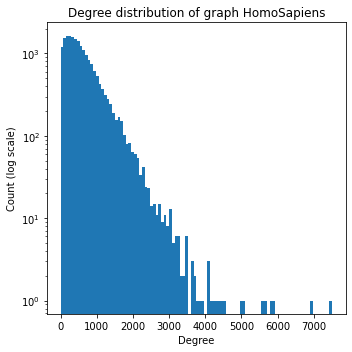

In [1]:
from grape.datasets.string import HomoSapiens
from grape import GraphVisualizer

graph = HomoSapiens()
GraphVisualizer(graph).plot_node_degree_distribution()

## What is a random walk?
In graph theory, a [random walk](https://en.wikipedia.org/wiki/Random_walk) is a path consisting of a sequence of nodes in a graph, where each step is taken randomly to a neighboring node. At each step, the probability of moving to a neighboring node is proportional to the weight of the corresponding edge. Random walks can be used for various graph-related tasks, such as estimating node centrality or generating node embeddings for machine learning applications.

A biased random walk is a random walk that is biased towards certain nodes or edges in the graph. In a biased random walk, the probability of moving to a neighboring node is not proportional to the edge weight but rather a function of some node or edge attributes, such as node degree or edge type. Biased random walks are often used in graph embedding techniques such as Node2Vec, which balances between a Breadth-First-Search (BFS) strategy and a Depth-First-Search (DFS) strategy to obtain embeddings that capture both local and global graph structures.

## The impact of node degrees on random walks

When performing a random walk on a graph with an exponential degree distribution, **the probability of visiting a node is proportional to its degree**. In other words, nodes with a higher degree are more likely to be visited during the random walk than nodes with a lower degree.

However, the probability distribution of visiting nodes with different degrees during the random walk will be different from the node degree distribution of the graph. Instead of an exponential distribution where nodes with a low degree are more common, the distribution of nodes visited during the random walk will be exponentially skewed towards nodes with a high degree.

Specifically, **nodes with a high degree will appear exponentially more frequently than nodes with a low degree**. This bias towards high-degree nodes in the random walk can result in a fine-grained representation of neighborhoods surrounding high-degree nodes but a coarse-grained representation of neighborhoods surrounding low-degree nodes, as mentioned earlier. This can be problematic in applications such as node classification or link prediction, where a balanced representation of different neighborhoods is desired.

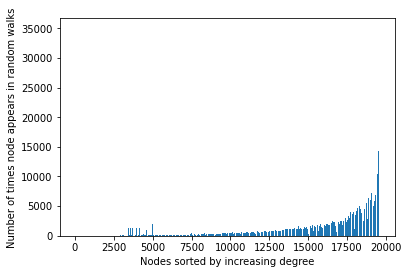

CPU times: user 55.4 s, sys: 694 ms, total: 56.1 s
Wall time: 26.8 s


In [2]:
%%time
from grape.datasets.string import HomoSapiens
import matplotlib.pyplot as plt
import numpy as np
from grape import GraphVisualizer

graph = HomoSapiens()

graph = graph.filter_from_names(min_edge_weight=700)

walks = graph.complete_walks(
    # Length of each walk
    walk_length=128,
    # Number of walks per node
    iterations=10,
    normalize_by_degree=False
)

counts_per_node = np.bincount(walks.flatten(), minlength=graph.get_number_of_nodes())

node_degrees = graph.get_node_degrees()

index = np.arange(graph.get_number_of_nodes())

index = sorted(index, key=lambda i: node_degrees[i])

plt.bar(np.arange(graph.get_number_of_nodes()), counts_per_node[index])
plt.xlabel("Nodes sorted by increasing degree")
plt.ylabel("Number of times node appears in random walks")
plt.show()

One solution to mitigate the exponential effect of the random walk is to **weight each step in the walk by the reciprocal of the node degree**. This means that nodes with a higher degree will have a smaller weight, making them less likely to be visited frequently during the random walk. Conversely, nodes with a lower degree will have a proportionally higher weight, making them more likely to be visited during the random walk. **By weighting the random walk in this manner, the exponential effect of the degree distribution is suppressed**.

While weighting the random walk may seem counterintuitive as it deviates from the original random walk without any weighting, we show that it actually leads to better performance in training models such as DeepWalk, Node2Vec, and partially Walklets, when applied to graph node embedding tasks. By using this weighted random walk approach, we obtain more balanced neighborhood representations for nodes across different degrees, leading to more robust and accurate predictive models. In the next section, we will show how to use the GRAPE library, a graph machine learning library that implements the degree normalization approach, to perform graph embedding using weighted random walks and how to evaluate the performance of the resulting embeddings.

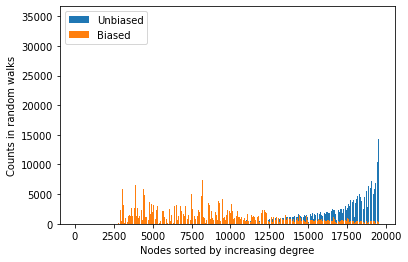

CPU times: user 1min 30s, sys: 859 ms, total: 1min 31s
Wall time: 55.7 s


In [3]:
%%time
from grape.datasets.string import HomoSapiens
import matplotlib.pyplot as plt
import numpy as np
from grape import GraphVisualizer

graph = HomoSapiens()

graph = graph.filter_from_names(min_edge_weight=700)

walks = graph.complete_walks(
    # Length of each walk
    walk_length=128,
    # Number of walks per node
    iterations=10,
    normalize_by_degree=False
)

biased_walks = graph.complete_walks(
    # Length of each walk
    walk_length=128,
    # Number of walks per node
    iterations=10,
    normalize_by_degree=True
)

counts_per_node = np.bincount(walks.flatten(), minlength=graph.get_number_of_nodes())
counts_per_node_biased = np.bincount(biased_walks.flatten(), minlength=graph.get_number_of_nodes())

node_degrees = graph.get_node_degrees()

index = np.arange(graph.get_number_of_nodes())

index = sorted(index, key=lambda i: node_degrees[i])

plt.bar(np.arange(graph.get_number_of_nodes()), counts_per_node[index], label="Unbiased")
plt.bar(np.arange(graph.get_number_of_nodes()), counts_per_node_biased[index], label="Biased")
plt.xlabel("Nodes sorted by increasing degree")
plt.ylabel("Counts in random walks")
plt.legend()
plt.show()

## What is Node Embedding?
Node embedding is a technique used in machine learning to represent nodes in a graph as feature vectors in a low-dimensional space. Node embeddings capture the structural information of the graph by preserving the similarity between nodes based on their connectivity patterns. These embeddings can be used as input features to various downstream machine learning tasks such as node classification, link prediction, or clustering.

### DeepWalk
[DeepWalk](https://arxiv.org/abs/1403.6652) is a graph embedding technique that uses random walks to generate node embeddings. The algorithm performs multiple random walks on the graph and treats each walk as a sentence. Then, it applies a language modeling technique called skip-gram to learn node embeddings based on the co-occurrence of nodes in the random walks. DeepWalk assumes that nodes that are close in the random walk are likely to have similar embeddings, thus capturing the local structure of the graph.

### Node2Vec
[Node2Vec](https://arxiv.org/abs/1607.00653) is a graph embedding technique that extends DeepWalk by introducing a biased random walk strategy. It balances between Breadth-First-Search (BFS) and Depth-First-Search (DFS) strategies to generate a set of random walks that capture both local and global structure of the graph. Node2Vec defines two parameters that control the BFS/DFS exploration: the return parameter and the in-out parameter. By varying these parameters, Node2Vec can generate embeddings that capture different types of structural information, such as community structure or structural equivalence.

### Walklets
[Walklets](https://arxiv.org/abs/1605.02115) is a method for learning multiscale representations of vertices in a network. It generates multiscale vertex relationships by subsampling short random walks on the vertices of a graph and skipping over steps in each random walk to generate a corpus of vertex pairs that are reachable via paths of a fixed length. This corpus can then be used to learn a series of latent representations, each of which captures successively higher-order relationships from the adjacency matrix.

## Datasets
[The STRING database](https://string-db.org/) provides protein-protein interaction graphs, where nodes represent proteins and edges indicate interactions between them. These graphs are widely used in bioinformatics and systems biology to understand cellular processes and disease mechanisms. A node embedding trained on such a graph could be used to identify functionally related proteins, predict protein-protein interactions, and classify proteins based on their functions.

### Homo Sapiens
The Homo Sapiens graph is a protein-protein interaction graph that contains 19,566 nodes and 5,969,249 edges. The maximum degree of this graph is 7507, which means that the most connected protein in this network is linked to 7507 other proteins. The filtered version of this graph, which has edges with a score inferior to 700 removed, contains 16,584 nodes and 252,833 edges, with a maximum degree of 747. The score ranges from 100 to 1000 and represents the likelihood of the existence of a given edge. Overall, the Homo Sapiens graph is a large and complex network that represents interactions between different proteins in the human body.

In the next cell of this Jupyter notebook, we will use the GRAPE library to compute the graph report of the Homo Sapiens graph. The report will provide information such as the number of nodes and edges, the connected components, and the degree centrality of the nodes. Additionally, the report will include details on the weights of the edges, the types of nodes, and the approximated isomorphic node types. The report will help us gain insights into the structure and characteristics of the graph, and identify potential modeling errors in the pipeline that produced the graph. 

In [4]:
from grape.datasets.string import HomoSapiens
graph = HomoSapiens().filter_from_names(min_edge_weight=700)

graph

<div class="graph-report"><style>.graph-report li {margin: 0.5em 0 0.5em 0;}.graph-report .paragraph {text-align: justify;word-break: break-all;}.graph-report .small-columns {column-count: 4;column-gap: 2em;}.graph-report .medium-columns {column-count: 3;column-gap: 2em;}.graph-report .large-columns {column-count: 2;column-gap: 2em;}.graph-report .single-column {}@media only screen and (max-width: 600px) {.graph-report .small-columns {column-count: 1;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 600px) and (max-width: 800px) {.graph-report .small-columns {column-count: 2;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 800px) and (max-width: 1024px) {.graph-report .small-columns {column-count: 3;}.graph-report .medium-columns {column-count: 2;}.graph-report .large-columns {column-count: 1;}}</style><h2>HomoSapiens</h2><p class="paragraph">The undirected graph HomoSapiens has 19.57K heterogeneous nodes and 252.98K edges. The graph contains 2.85K connected components (of which 2.75K are disconnected nodes), with the largest one containing 16.58K nodes and the smallest one containing a single node. The RAM requirements for the nodes and edges data structures are 2.67MB and 2.18MB respectively.</p><h3 style="margin: 1em 0 0 0;">Degree centrality</h3><p class="paragraph">The minimum node degree is 0, the maximum node degree is 747, the mode degree is 0, the mean degree is 25.86 and the node degree median is 9.</p><p class="paragraph">The nodes with the highest degree centrality are 9606.ENSP00000272317 (degree 747 and node types BTO:0000000, BTO:0000042, BTO:0000058, BTO:0000080, BTO:0000081 and other 907), 9606.ENSP00000269305 (degree 723 and node types BTO:0000000, BTO:0000003, BTO:0000018, BTO:0000042, BTO:0000058 and other 1.35K), 9606.ENSP00000388107 (degree 669 and node types BTO:0000000, BTO:0000042, BTO:0000047, BTO:0000080, BTO:0000081 and other 884), 9606.ENSP00000441543 (degree 620 and node types BTO:0000000, BTO:0000020, BTO:0000042, BTO:0000058, BTO:0000080 and other 869) and 9606.ENSP00000362680 (degree 572 and node types BTO:0000000, BTO:0000042, BTO:0000089, BTO:0000131, BTO:0000132 and other 1.17K).</p><h3 style="margin: 1em 0 0 0;">Weights</h3><p class="paragraph">The minimum edge weight is 700, the maximum edge weight is 999 and the total edge weight is 437919420. The RAM requirement for the edge weights data structure is 2.02MB.</p><h3 style="margin: 1em 0 0 0;">Node types</h3><p class="paragraph">The graph has 62.23K node types, of which the 10 most common are GO:0110165 (17.79K nodes, 90.91%), GO:0009987 (15.02K nodes, 76.79%), BTO:0000000 (14.94K nodes, 76.37%), BTO:0000042 (14.89K nodes, 76.13%), GO:0005622 (14.28K nodes, 72.96%), GOCC:0110165 (13.85K nodes, 70.80%), GO:0043226 (13.52K nodes, 69.07%), BTO:0001489 (12.62K nodes, 64.49%), GO:0043229 (12.53K nodes, 64.03%) and GO:0005488 (12.52K nodes, 63.97%). The node types are multi-label, and the node with most node types has 1379 node types. The RAM requirement for the node types data structure is 19.13MB.</p><h4 style="margin: 1em 0 0 0;">Approximated isomorphic node types</h4><p class="paragraph">Approximated isomorphic node types groups are node types describing exactly the same set of nodes. Since the graph has a high number of node types (> 50.00K) we use an approximated version of the node types isomorphisms detection. Note that hash collisions and false positives are possible. It is possible to execute the exact computation with the <code>get_isomorphic_node_type_ids_groups</code> method. The presence of such duplicated node types suggests a potential modelling error in the pipeline that has produced this graph. 9.34K isomorphic node types groups were detected in this graph.</p><ol><li><p class="paragraph">Isomorphic node type group containing 3 node types (5.86K nodes, 29.93%), whic

### Deepwalk on Homo sapiens
Running Deepwalk on Homo sapiens involves generating random walks on the graph and using them to train a Skip-Gram model to learn the node embeddings. These embeddings capture the structural and semantic information of the nodes in the graph, which can be used for downstream tasks such as node classification and link prediction. However, one limitation of Deepwalk is that it uses random walks that treats all nodes equally, regardless of their degree, which can result in overemphasis on high-degree nodes and underemphasis on low-degree nodes.

In [8]:
%%time
from grape.embedders import DeepWalkSkipGramEnsmallen

model = DeepWalkSkipGramEnsmallen(
    normalize_by_degree=False
)

not_normalized_deepwalk_embedding = model.fit_transform(graph)

/home/luca/anaconda3/lib/python3.9/site-packages/embiggen/utils/abstract_models/abstract_embedding_model.py:178: UserWarning: Please be advised that the HomoSapiens graph contains 2752 disconnected nodes. Consider that node embedding algorithms that only use topological information such as CBOW, GloVe, SPINE and SkipGram are not able to provide meaningful embeddings for these nodes, and their embedding will be generally far away from any other node. It is also possible that all disconnected nodes will receive a relatively similar node embedding. Consider dropping them by using the `graph.remove_disconnected_nodes()` method.
  warnings.warn(


CPU times: user 33min 25s, sys: 2.3 s, total: 33min 27s
Wall time: 1min 26s


To overcome the degree bias, one can use the degree-normalized random walks instead of the regular random walks in Deepwalk. In this approach, the probability of visiting a node during a random walk is inversely proportional to its degree, ensuring that the random walks visit high-degree nodes much less frequently than low-degree nodes. This results in a more balanced representation of the nodes in the graph, and can lead to improved performance on downstream tasks.

In [9]:
%%time
from grape.embedders import DeepWalkSkipGramEnsmallen

model = DeepWalkSkipGramEnsmallen(
    normalize_by_degree=True
)

degree_normalized_deepwalk_embedding = model.fit_transform(graph)

/home/luca/anaconda3/lib/python3.9/site-packages/embiggen/utils/abstract_models/abstract_embedding_model.py:178: UserWarning: Please be advised that the HomoSapiens graph contains 2752 disconnected nodes. Consider that node embedding algorithms that only use topological information such as CBOW, GloVe, SPINE and SkipGram are not able to provide meaningful embeddings for these nodes, and their embedding will be generally far away from any other node. It is also possible that all disconnected nodes will receive a relatively similar node embedding. Consider dropping them by using the `graph.remove_disconnected_nodes()` method.
  warnings.warn(


CPU times: user 26min 2s, sys: 2.46 s, total: 26min 4s
Wall time: 1min 7s


Now, let's display the two embedding using TSNE to visually compare how they differ.

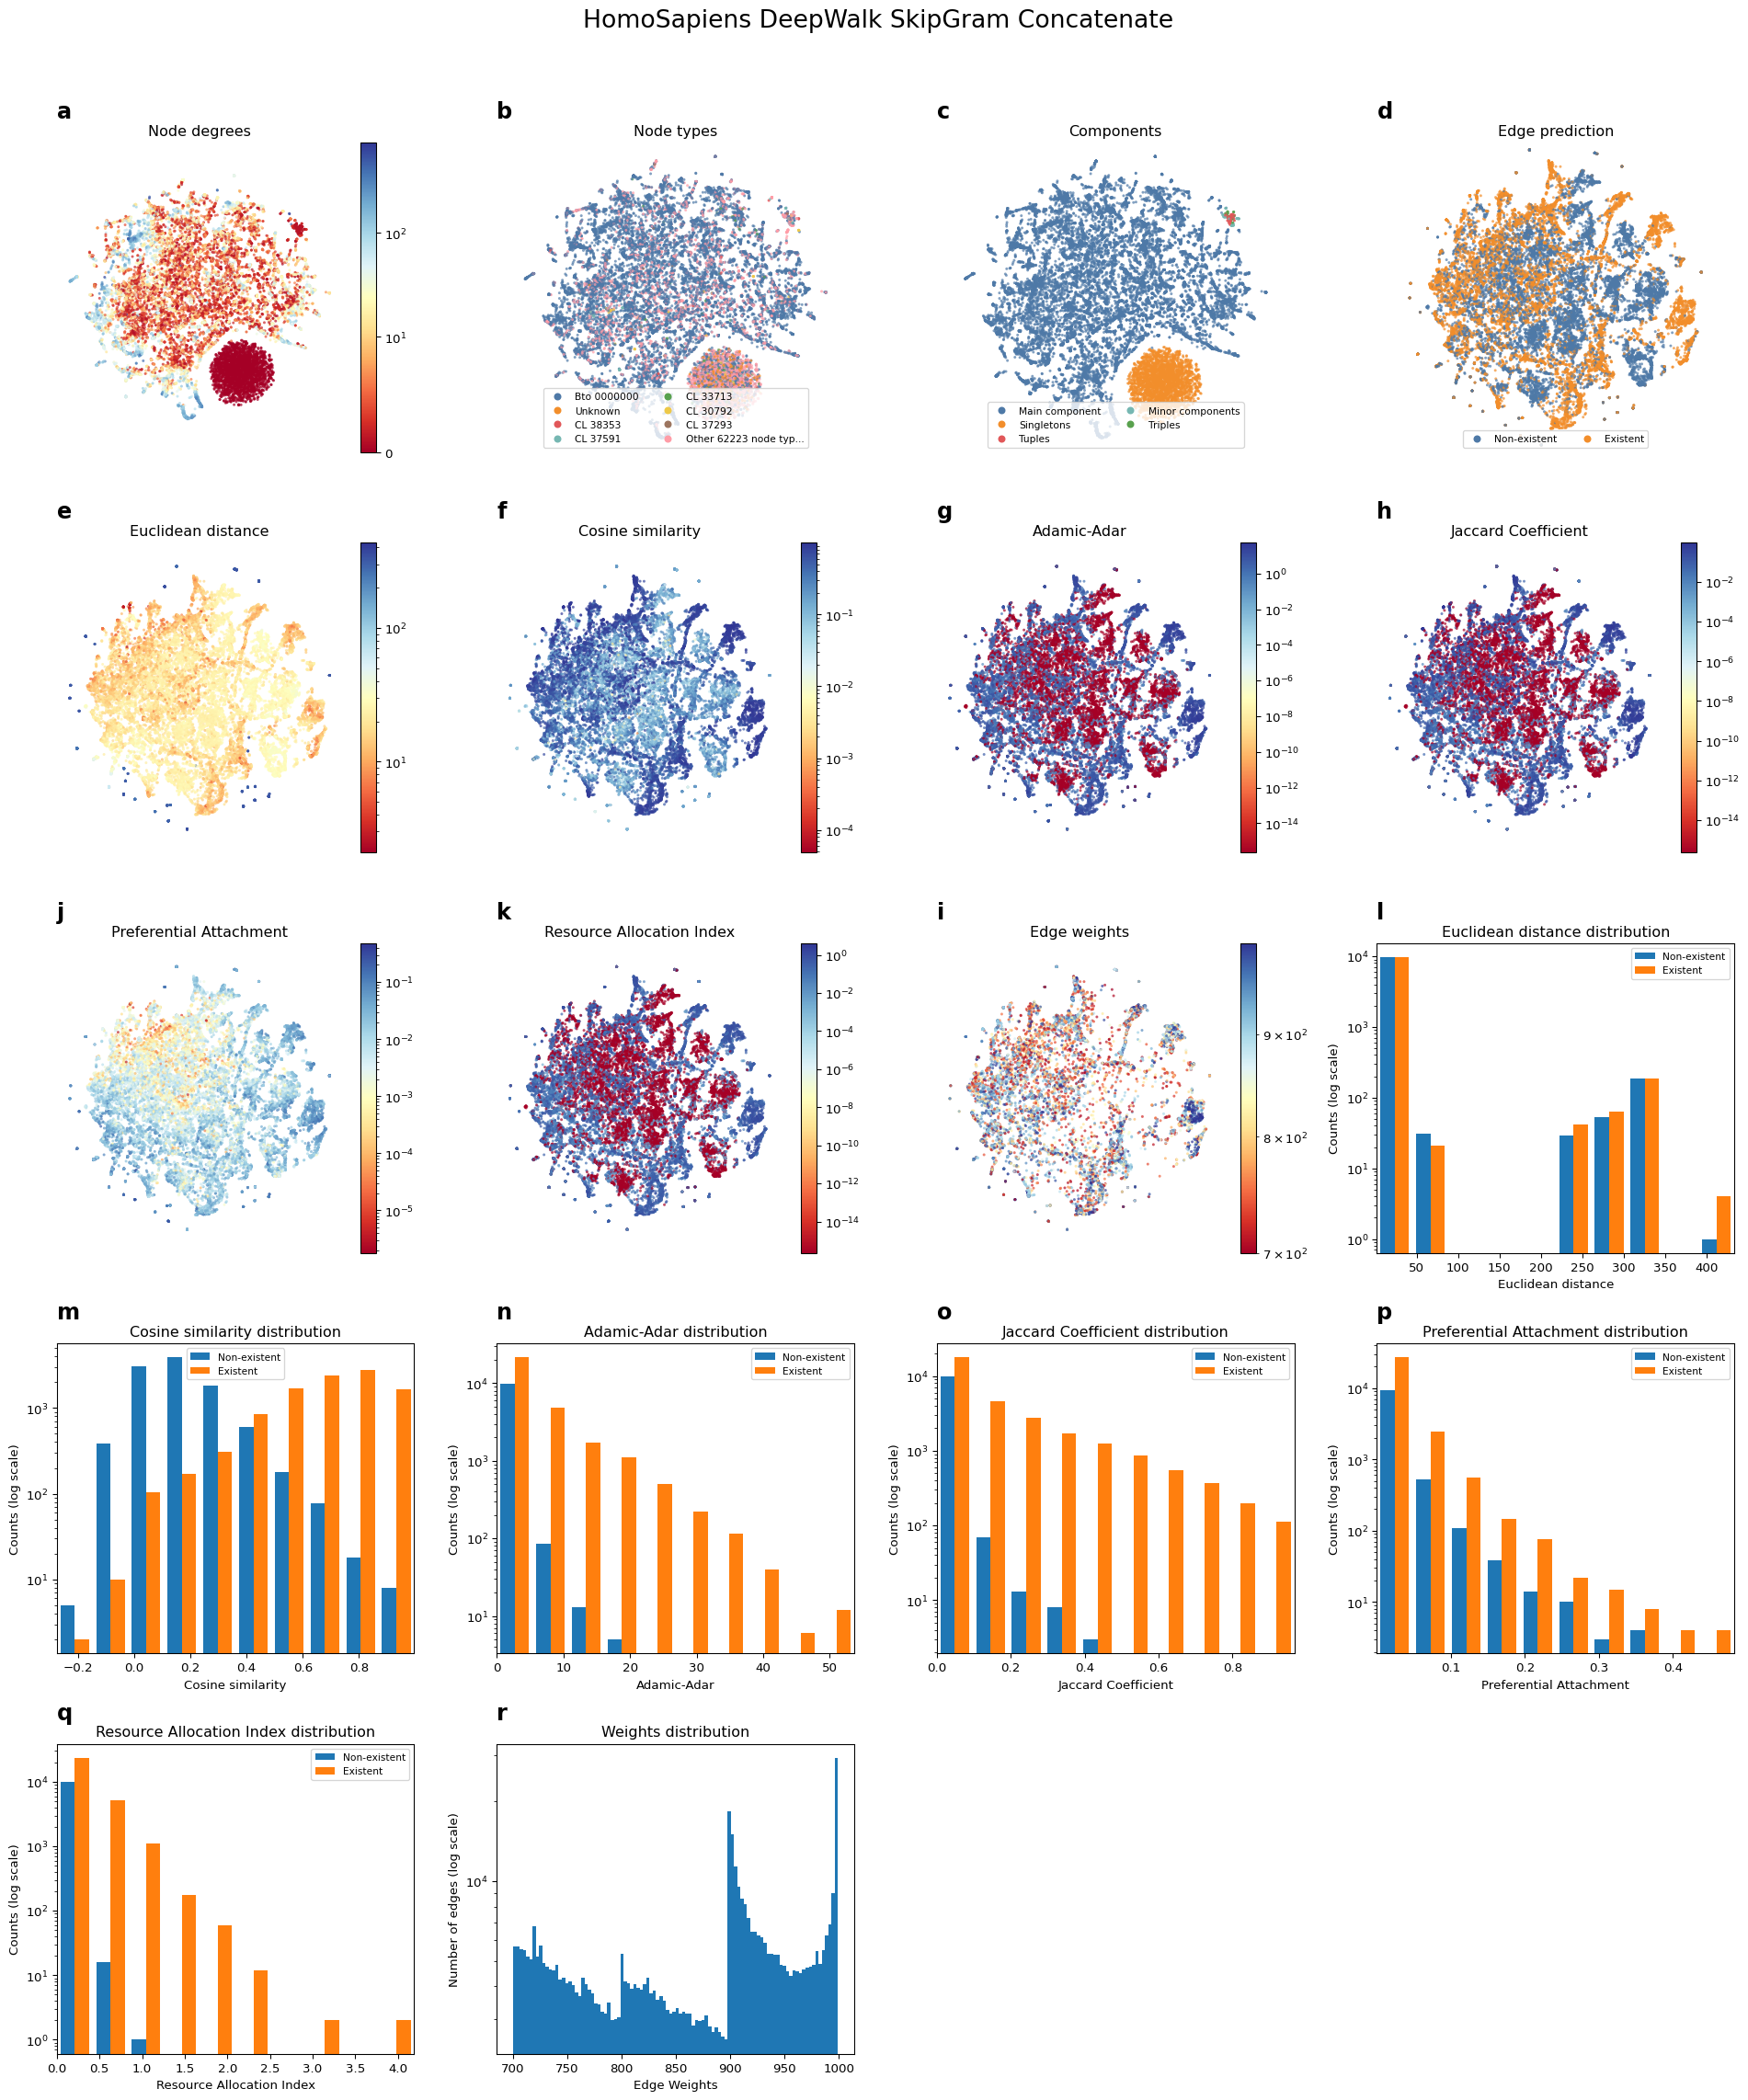

In [10]:
from grape import GraphVisualizer

GraphVisualizer(graph).fit_and_plot_all(not_normalized_deepwalk_embedding)

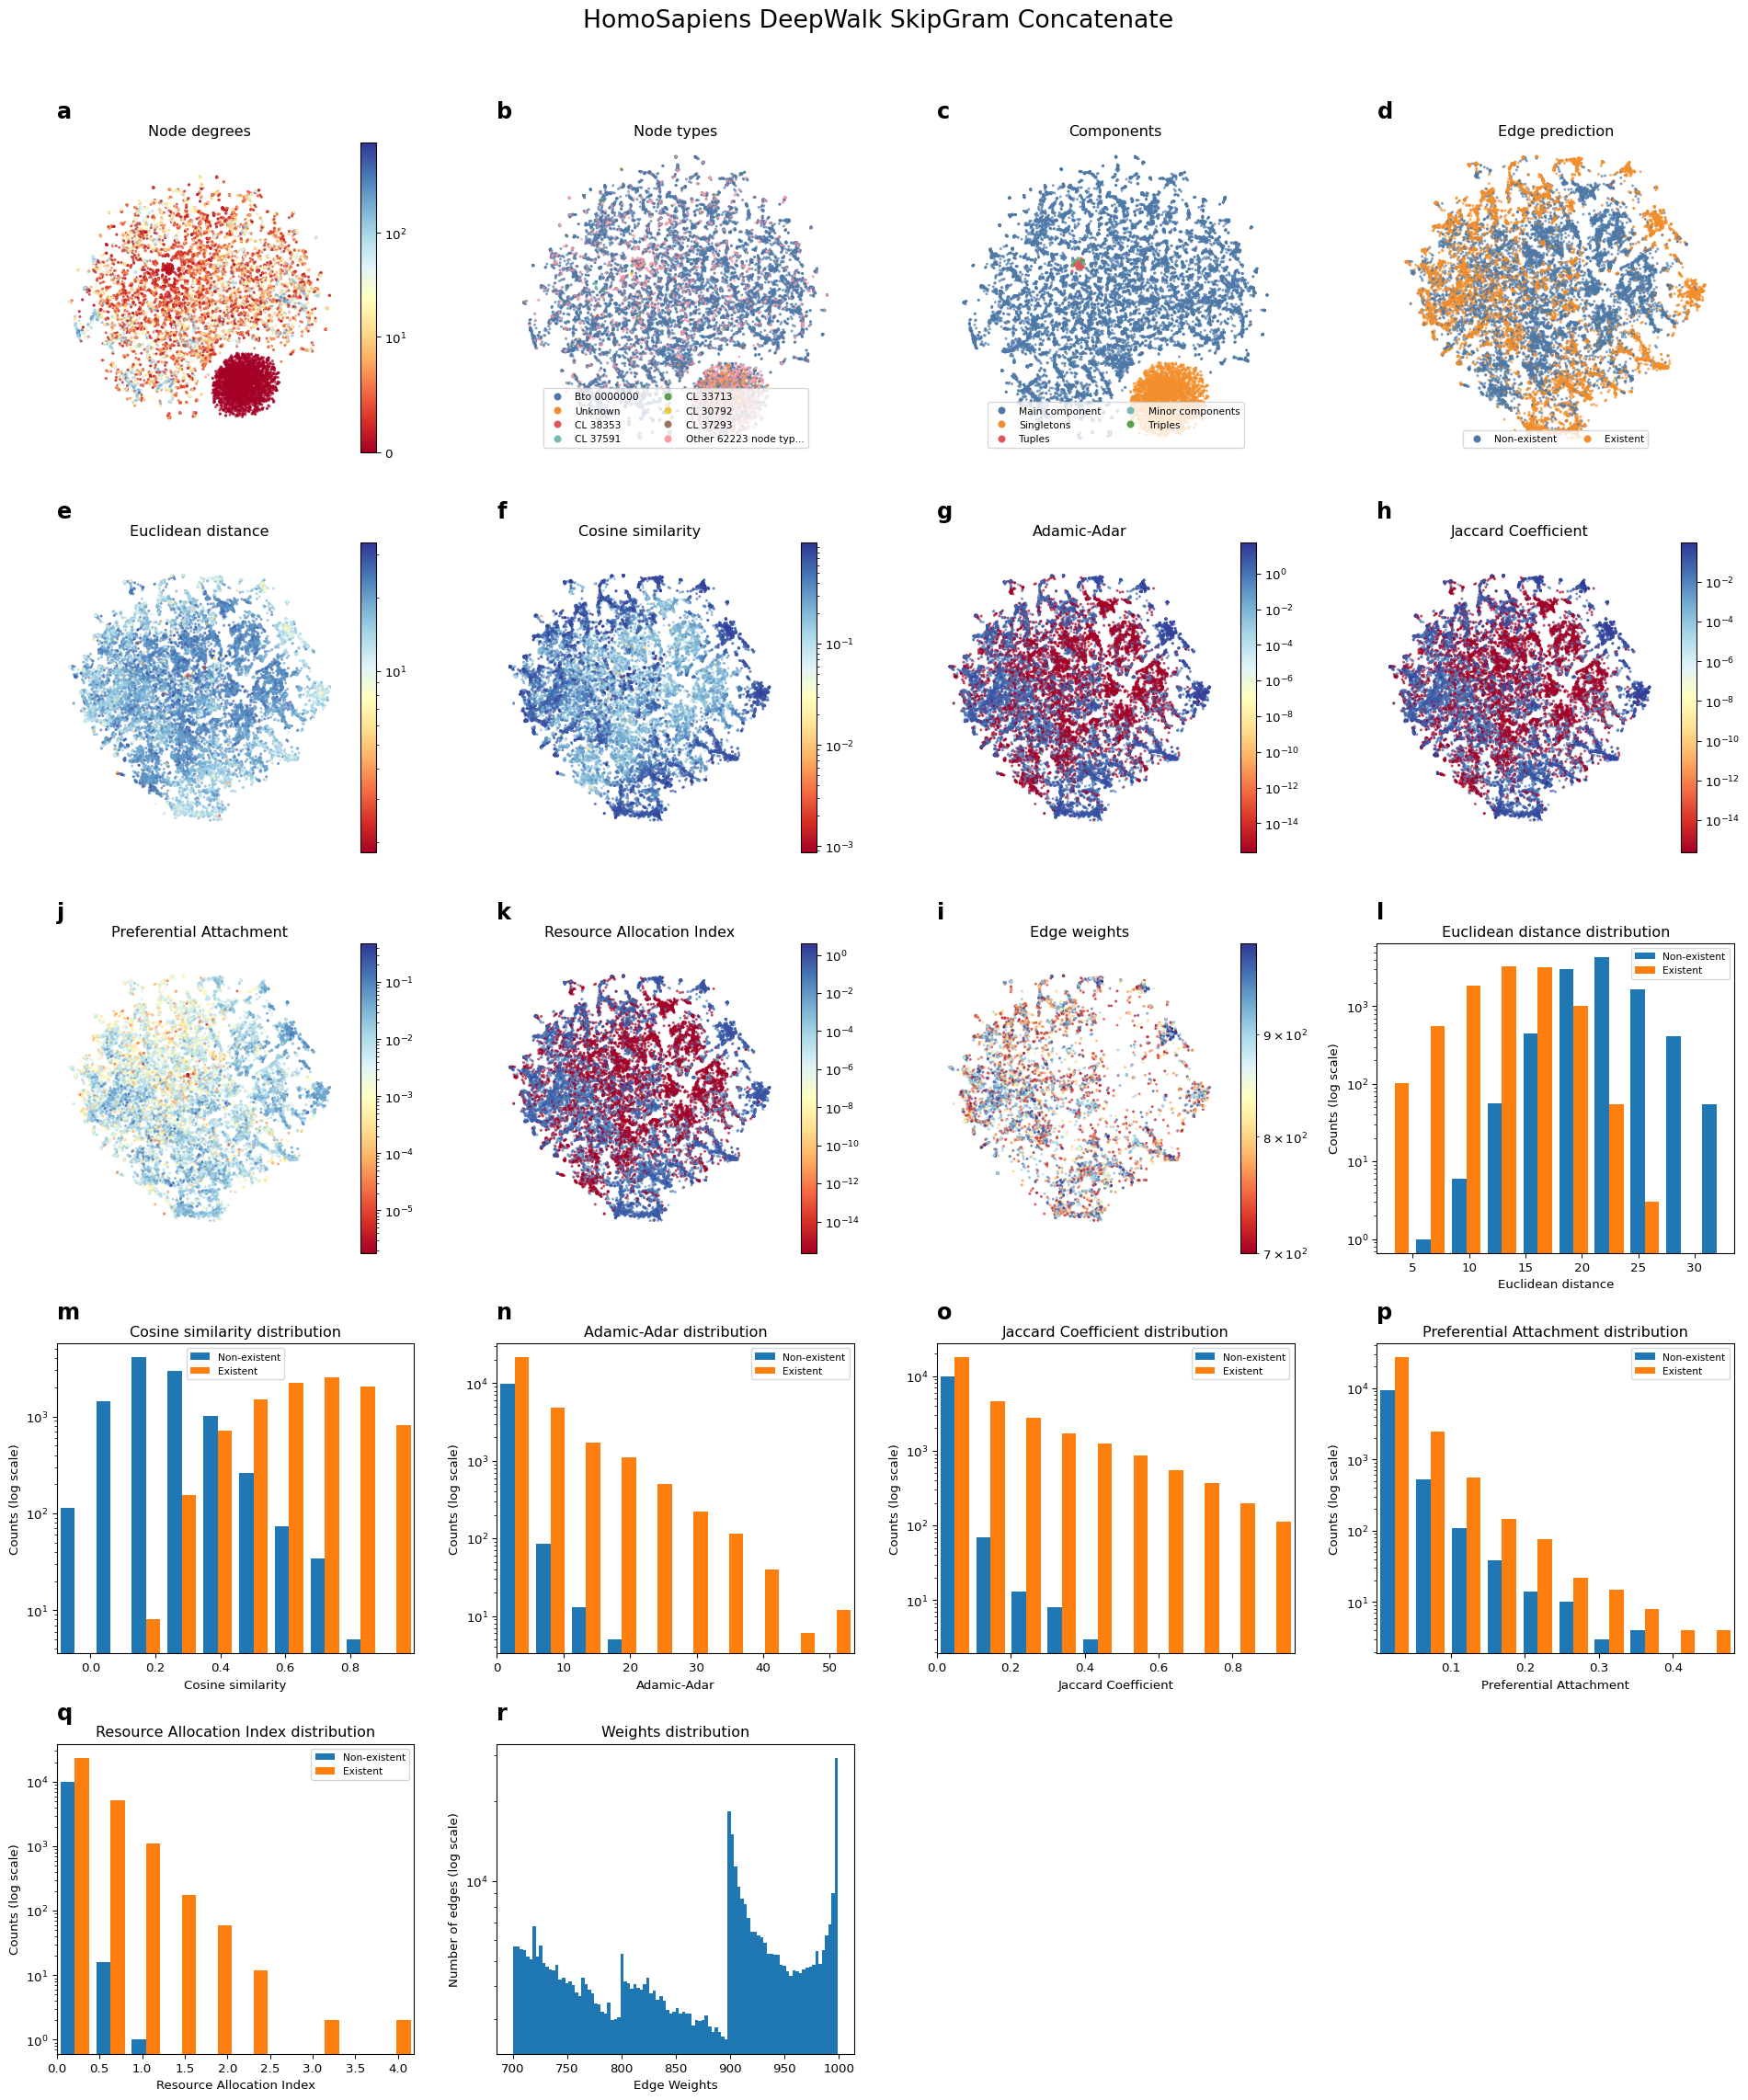

In [11]:
from grape import GraphVisualizer

GraphVisualizer(graph).fit_and_plot_all(degree_normalized_deepwalk_embedding)

The degree-normalized version of Deepwalk demonstrates an improvement in balanced accuracy of about 4% over 5 holdouts when using a simple tree classifier for edge prediction. This is an important finding because it suggests that the degree-normalized random walks are able to capture more meaningful information about the graph structure. Additionally, the L2 distance between embeddings is much more well-behaved, indicating that they may be much more easy for a model to learn upon as they form two very clean gaussian distributions.

However, **it is important to note that all of these visualizations are based on the same graph that was used to train the embedding, so it is necessary to evaluate the performance on a separate train-test split**. With this in mind, we can now proceed to evaluating the performance of the degree-normalized version of Deepwalk on a train-test split.

In the following jupyter cells, we will run the pipelines for evaluating the performance of DeepWalk with and without node-degree normalization. To do this, we will [use the GRAPE edge prediction evaluation pipeline](https://github.com/AnacletoLAB/grape/blob/main/tutorials/Using%20the%20edge%20prediction%20pipeline.ipynb), which is a tool for standardized evaluation on a given task, with an arbitrary dataset.

In this small examples we only run TWO holdouts, but in a real experimental setup run at least 10 as we did in the associated paper experiment [which you can find here](https://github.com/LucaCappelletti94/right_laplacian_node2vec/tree/main).

Also, in the work from the paper we have focused the evaluation on the low-degree nodes by defining Goldilock areas of interest in the paper of low-degree nodes, while here we are running a global holdout. This means that the impact of improving the embedding of low degree nodes will be measured much less, as the test set will include also several high degree nodes.

In [20]:
from tqdm.auto import tqdm
import pandas as pd
from grape import Graph
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction

def string_graph_normalization(graph: Graph) -> Graph:
    """Apply standard STRING PPI normalization.
    
    Parameters
    --------------------
    graph: Graph
        The STRING PPI graph to normalize.
    """
    return graph.filter_from_names(min_edge_weight=700)\
        .remove_components(top_k_components=1)\
        .divide_edge_weights(1000.0)

deepwalk_results = pd.concat([
    edge_prediction_evaluation(
        holdouts_kwargs=dict(
            train_size=0.8
        ),
        graphs=[
            HomoSapiens()
        ],
        models=[
            DecisionTreeEdgePrediction(),
            RandomForestEdgePrediction(),
        ],
        evaluation_schema="Connected Monte Carlo",
        number_of_holdouts=2,
        node_features=DeepWalkSkipGramEnsmallen(
            normalize_by_degree=normalize_by_degree,
            enable_cache=True
        ),
        graph_callback=string_graph_normalization,
        smoke_test=False,
        enable_cache=True,
        verbose=True
    )
    for normalize_by_degree in tqdm(
        (True, False),
        desc="Experiment of DeepWalk",
        leave=False,
        dynamic_ncols=True
    )
])

deepwalk_results

Experiment of DeepWalk:   0%|                                                                                 …

Evaluating on HomoSapiens:   0%|                                                                              …

  0%|                                                                                                         …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

/home/luca/anaconda3/lib/python3.9/site-packages/cache_decorator/backends/pandas_csv_backend.py:93: UserWarning: The column 'number_of_slurm_nodes' contains values of multiple types therefore the data will be saved as required but we don't guarantee that they will be loaded as the same types as pandas does not support this.
Consider using pickle (.pkl) or compress pickle (.pkl.gz, ...) to cache this complex type in a consistent manner.
  warnings.warn("The column '{}'".format(
/home/luca/anaconda3/lib/python3.9/site-packages/cache_decorator/backends/pandas_csv_backend.py:93: UserWarning: The column '('model_parameters', 'splitter')' contains values of multiple types therefore the data will be saved as required but we don't guarantee that they will be loaded as the same types as pandas does not support this.
Consider using pickle (.pkl) or compress pickle (.pkl.gz, ...) to cache this complex type in a consistent manner.
  warnings.warn("The column '{}'".format(
/home/luca/anaconda3/lib/

  0%|                                                                                                         …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

/home/luca/anaconda3/lib/python3.9/site-packages/cache_decorator/backends/pandas_csv_backend.py:93: UserWarning: The column '('model_parameters', 'splitter')' contains values of multiple types therefore the data will be saved as required but we don't guarantee that they will be loaded as the same types as pandas does not support this.
Consider using pickle (.pkl) or compress pickle (.pkl.gz, ...) to cache this complex type in a consistent manner.
  warnings.warn("The column '{}'".format(
/home/luca/anaconda3/lib/python3.9/site-packages/cache_decorator/backends/pandas_csv_backend.py:93: UserWarning: The column '('model_parameters', 'max_features')' contains values of multiple types therefore the data will be saved as required but we don't guarantee that they will be loaded as the same types as pandas does not support this.
Consider using pickle (.pkl) or compress pickle (.pkl.gz, ...) to cache this complex type in a consistent manner.
  warnings.warn("The column '{}'".format(
/home/luca

evaluation_mode  train_size  validation_unbalance_rate  \
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   

   use_scale_free_distribution  \
0                         True   
1                         True   
0                         True   
1                         True   
0                         True   
1                         True   
0                         True   
1                         True   
0                         True   
1                         True   
0                         True   
1                         True   
0                         True   
1                         True   
0                         True   
1                         True   

   validation_sample_only_edges_with_heterogeneous_node_types  \
0                                              False            
1                                              False            
0                                              False            
1                                              False            
0                                              False            
1                                              False            
0                                              False            
1                                              False            
0                                              False            
1                                              False            
0                                              False            
1                                              False            
0                                              False            
1                                              False            
0                                              False            
1                                              False            

   false_discovery_rate  f1_score  miss_rate  precision  \
0              0.328848  0.727761   0.205200   0.671152   
1              0.345224  0.693806   0.262216   0.654776   
0              0.078275  0.933014   0.055417   0.921725   
1              0.087408  0.888977   0.133447   0.912592   
0              0.333229  0.732049   0.188504   0.666771   
1              0.350522  0.698579   0.244290   0.649478   
0              0.084675  0.928796   0.057330   0.915325   
1              0.092011  0.886337   0.134307   0.907989   
0              0.351332  0.724002   0.180866   0.648668   
1              0.360764  0.702105   0.221310   0.639236   
0              0.125982  0.906396   0.058735   0.874018   
1              0.133201  0.879255   0.107926   0.866799   
0              0.357985  0.721882   0.175556   0.642015   
1              0.369093  0.699395   0.215437   0.630907   
0              0.112466  0.909914   0.066549   0.887534   
1              0.117501  0.880290   0.121908   0.882499   

   positive_likelyhood_ratio  ...  \
0                   2.040917  ...   
1                   1.896670  ...   
0                  11.775470  ...   
1                  10.440553  ...   
0                   2.000939  ...   
1                   1.852890  ...   
0                  10.809876  ...

In [28]:
deepwalk_results.groupby([
    "evaluation_mode",
    ('features_parameters', 'normalize_by_degree'),
    "model_name"
]).agg(["mean", "std"])[["matthews_correlation_coefficient", "f1_score", "accuracy"]]

/tmp/ipykernel_1458721/266742799.py:1: FutureWarning: ['task_name', 'library_name', 'graph_name', 'evaluation_schema', 'holdouts_kwargs', 'python_version', 'platform', 'features_names', ('model_parameters', 'edge_embedding_method'), ('model_parameters', 'criterion'), ('model_parameters', 'splitter'), ('model_parameters', 'max_features'), ('features_parameters', 'clipping_value'), ('features_parameters', 'learning_rate'), ('features_parameters', 'learning_rate_decay'), ('features_parameters', 'central_nodes_embedding_path'), ('features_parameters', 'contextual_nodes_embedding_path'), ('features_parameters', 'stochastic_downsample_by_degree'), ('features_parameters', 'normalize_learning_rate_by_degree'), ('features_parameters', 'use_scale_free_distribution'), ('features_parameters', 'dtype'), ('features_parameters', 'verbose')] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  deepwalk_res

matthews_correlation_coefficient  \
                                                                                                                mean   
evaluation_mode (features_parameters, normalize_by_degree) model_name                                                  
test            False                                      Decision Tree Classifier                         0.347595   
                True                                       Decision Tree Classifier                         0.352118   
                                                           Random Forest Classifier                         0.781683   
                False                                      Decision Tree Classifier                         0.335686   
                                                           Random Forest Classifier                         0.758249   
train           False                                      Decision Tree Classifier                         0.389151   
                True                                       Decision Tree Classifier                         0.414140   
                                                           Random Forest Classifier                         0.860240   
                False                                      Decision Tree Classifier                         0.380419   
                                                           Random Forest Classifier                         0.812123   

                                                                                               \
                                                                                          std   
evaluation_mode (features_parameters, normalize_by_degree) model_name                           
test            False                                      Decision Tree Classifier       NaN   
                True                                       Decision Tree Classifier  0.000688   
                                                           Random Forest Classifier  0.004059   
                False                                      Decision Tree Classifier       NaN   
                                                           Random Forest Classifier  0.004156   
train           False                                      Decision Tree Classifier       NaN   
                True                                       Decision Tree Classifier  0.002422   
                                                           Random Forest Classifier  0.006212   
                False                                      Decision Tree Classifier       NaN   
                                                           Random Forest Classifier  0.005851   

                                                                                     f1_score  \
                                                                                         mean   
evaluation_mode (features_parameters, normalize_by_degree) model_name                           
test            False                                      Decision Tree Classifier  0.702105   
                True                                       Decision Tree Classifier  0.696192   
                                                           Random Forest Classifier  0.887657   
                False                                      Decision Tree Classifier  0.699395   
                                                           Random Forest Classifier  0.879772   
train           False                                      Decision Tree Classifier  0.724002   
                True                                       Decision Tree Classifier  0.729905   
                                                           Random Forest Classifier  0.930905   
                False                                      Decision Tree Classifier  0.721882   
                                                           Random Forest Classifier  0.908155   


We find an improvement for the DeepWalk performance! Though more holdouts are needed to determine whether it is statistically significant. In the paper we did 10, with Goldilock holdouts, and there it resulted statistically significant.

In the next cell we run the same for Node2Vec:

In [21]:
import pandas as pd
from grape import Graph
from grape.embedders import Node2VecSkipGramEnsmallen
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction


node2vec_results = pd.concat([
    edge_prediction_evaluation(
        holdouts_kwargs=dict(
            train_size=0.8
        ),
        graphs=[
            HomoSapiens()
        ],
        models=[
            DecisionTreeEdgePrediction(),
            RandomForestEdgePrediction(),
        ],
        evaluation_schema="Connected Monte Carlo",
        number_of_holdouts=2,
        node_features=Node2VecSkipGramEnsmallen(
            normalize_by_degree=normalize_by_degree,
            enable_cache=True
        ),
        graph_callback=string_graph_normalization,
        smoke_test=False,
        enable_cache=True,
        verbose=True
    )
    for normalize_by_degree in tqdm(
        (True, False),
        desc="Experiment of Node2Vec",
        leave=False,
        dynamic_ncols=True
    )
])

node2vec_results

Experiment of Node2Vec:   0%|                                                                                 …

Evaluating on HomoSapiens:   0%|                                                                              …

  0%|                                                                                                         …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

/home/luca/anaconda3/lib/python3.9/site-packages/cache_decorator/backends/pandas_csv_backend.py:93: UserWarning: The column '('model_parameters', 'splitter')' contains values of multiple types therefore the data will be saved as required but we don't guarantee that they will be loaded as the same types as pandas does not support this.
Consider using pickle (.pkl) or compress pickle (.pkl.gz, ...) to cache this complex type in a consistent manner.
  warnings.warn("The column '{}'".format(
/home/luca/anaconda3/lib/python3.9/site-packages/cache_decorator/backends/pandas_csv_backend.py:93: UserWarning: The column '('model_parameters', 'max_features')' contains values of multiple types therefore the data will be saved as required but we don't guarantee that they will be loaded as the same types as pandas does not support this.
Consider using pickle (.pkl) or compress pickle (.pkl.gz, ...) to cache this complex type in a consistent manner.
  warnings.warn("The column '{}'".format(
/home/luca

  0%|                                                                                                         …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

/home/luca/anaconda3/lib/python3.9/site-packages/cache_decorator/backends/pandas_csv_backend.py:93: UserWarning: The column '('model_parameters', 'splitter')' contains values of multiple types therefore the data will be saved as required but we don't guarantee that they will be loaded as the same types as pandas does not support this.
Consider using pickle (.pkl) or compress pickle (.pkl.gz, ...) to cache this complex type in a consistent manner.
  warnings.warn("The column '{}'".format(
/home/luca/anaconda3/lib/python3.9/site-packages/cache_decorator/backends/pandas_csv_backend.py:93: UserWarning: The column '('model_parameters', 'max_features')' contains values of multiple types therefore the data will be saved as required but we don't guarantee that they will be loaded as the same types as pandas does not support this.
Consider using pickle (.pkl) or compress pickle (.pkl.gz, ...) to cache this complex type in a consistent manner.
  warnings.warn("The column '{}'".format(
/home/luca

Evaluating on HomoSapiens:   0%|                                                                              …

  0%|                                                                                                         …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

/home/luca/anaconda3/lib/python3.9/site-packages/cache_decorator/backends/pandas_csv_backend.py:93: UserWarning: The column '('model_parameters', 'splitter')' contains values of multiple types therefore the data will be saved as required but we don't guarantee that they will be loaded as the same types as pandas does not support this.
Consider using pickle (.pkl) or compress pickle (.pkl.gz, ...) to cache this complex type in a consistent manner.
  warnings.warn("The column '{}'".format(
/home/luca/anaconda3/lib/python3.9/site-packages/cache_decorator/backends/pandas_csv_backend.py:93: UserWarning: The column '('model_parameters', 'max_features')' contains values of multiple types therefore the data will be saved as required but we don't guarantee that they will be loaded as the same types as pandas does not support this.
Consider using pickle (.pkl) or compress pickle (.pkl.gz, ...) to cache this complex type in a consistent manner.
  warnings.warn("The column '{}'".format(
/home/luca

  0%|                                                                                                         …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

/home/luca/anaconda3/lib/python3.9/site-packages/cache_decorator/backends/pandas_csv_backend.py:93: UserWarning: The column '('model_parameters', 'splitter')' contains values of multiple types therefore the data will be saved as required but we don't guarantee that they will be loaded as the same types as pandas does not support this.
Consider using pickle (.pkl) or compress pickle (.pkl.gz, ...) to cache this complex type in a consistent manner.
  warnings.warn("The column '{}'".format(
/home/luca/anaconda3/lib/python3.9/site-packages/cache_decorator/backends/pandas_csv_backend.py:93: UserWarning: The column '('model_parameters', 'max_features')' contains values of multiple types therefore the data will be saved as required but we don't guarantee that they will be loaded as the same types as pandas does not support this.
Consider using pickle (.pkl) or compress pickle (.pkl.gz, ...) to cache this complex type in a consistent manner.
  warnings.warn("The column '{}'".format(
/home/luca

evaluation_mode  train_size  validation_unbalance_rate  \
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   

   use_scale_free_distribution  \
0                         True   
1                         True   
0                         True   
1                         True   
0                         True   
1                         True   
0                         True   
1                         True   
0                         True   
1                         True   
0                         True   
1                         True   
0                         True   
1                         True   
0                         True   
1                         True   

   validation_sample_only_edges_with_heterogeneous_node_types  accuracy  \
0                                              False           0.707628   
1                                              False           0.680142   
0                                              False           0.931701   
1                                              False           0.891772   
0                                              False           0.707191   
1                                              False           0.680750   
0                                              False           0.930940   
1                                              False           0.892138   
0                                              False           0.701034   
1                                              False           0.679119   
0                                              False           0.905177   
1                                              False           0.879630   
0                                              False           0.682749   
1                                              False           0.665928   
0                                              False           0.905422   
1                                              False           0.879388   

   fall_out  precision  negative_likelyhood_ratio  diagnostic_odds_ratio  ...  \
0  0.380314   0.676572                   0.329895               6.341040  ...   
1  0.378310   0.661287                   0.420476               4.643197  ...   
0  0.077714   0.923722                   0.063845             189.678525  ...   
1  0.080240   0.915002                   0.148099              72.687995  ...   
0  0.372235   0.678790                   0.339908               6.217057  ...   
1  0.374434   0.662784                   0.422122               4.656134  ...   
0  0.081870   0.920175                   0.061266             188.153719  ...   
1  0.081753   0.913743                   0.145898              72.607045  ...   
0  0.394738   0.668717                   0.335714               6.012753  ...   
1  0.397581   0.655296                   0.405334               4.690058  ...   
0  0.130165   0.878428                   0.068382             105.664835  ...   
1  0.131578   0.871307                   0.125702              53.861034  ...   
0  0.477191   0.638459                   0.300894               5.868970 

In [26]:
node2vec_results.groupby([
    "evaluation_mode",
    ('features_parameters', 'normalize_by_degree'),
    "model_name"
]).agg(["mean", "std"])[["matthews_correlation_coefficient", "f1_score", "accuracy"]]

/tmp/ipykernel_1458721/1393205614.py:1: FutureWarning: ['task_name', 'library_name', 'graph_name', 'evaluation_schema', 'holdouts_kwargs', 'python_version', 'platform', 'features_names', ('model_parameters', 'edge_embedding_method'), ('model_parameters', 'criterion'), ('model_parameters', 'splitter'), ('model_parameters', 'max_features'), ('features_parameters', 'clipping_value'), ('features_parameters', 'return_weight'), ('features_parameters', 'explore_weight'), ('features_parameters', 'learning_rate'), ('features_parameters', 'learning_rate_decay'), ('features_parameters', 'central_nodes_embedding_path'), ('features_parameters', 'contextual_nodes_embedding_path'), ('features_parameters', 'stochastic_downsample_by_degree'), ('features_parameters', 'normalize_learning_rate_by_degree'), ('features_parameters', 'use_scale_free_distribution'), ('features_parameters', 'dtype'), ('features_parameters', 'verbose')] did not aggregate successfully. If any error is raised this will raise in a 

matthews_correlation_coefficient  \
                                                                                                                mean   
evaluation_mode (features_parameters, normalize_by_degree) model_name                                                  
test            False                                      Decision Tree Classifier                         0.354412   
                                                           Random Forest Classifier                         0.759130   
                True                                       Decision Tree Classifier                         0.363247   
                                                           Random Forest Classifier                         0.785061   
train           False                                      Decision Tree Classifier                         0.397710   
                                                           Random Forest Classifier                         0.812379   
                True                                       Decision Tree Classifier                         0.420771   
                                                           Random Forest Classifier                         0.862859   

                                                                                               \
                                                                                          std   
evaluation_mode (features_parameters, normalize_by_degree) model_name                           
test            False                                      Decision Tree Classifier  0.011479   
                                                           Random Forest Classifier  0.000454   
                True                                       Decision Tree Classifier  0.000672   
                                                           Random Forest Classifier  0.000405   
train           False                                      Decision Tree Classifier  0.016889   
                                                           Random Forest Classifier  0.000010   
                True                                       Decision Tree Classifier  0.001498   
                                                           Random Forest Classifier  0.000985   

                                                                                     f1_score  \
                                                                                         mean   
evaluation_mode (features_parameters, normalize_by_degree) model_name                           
test            False                                      Decision Tree Classifier  0.704834   
                                                           Random Forest Classifier  0.880459   
                True                                       Decision Tree Classifier  0.697626   
                                                           Random Forest Classifier  0.888951   
train           False                                      Decision Tree Classifier  0.726829   
                                                           Random Forest Classifier  0.908325   
                True                                       Decision Tree Classifier  0.729999   
                                                           Random Forest Classifier  0.932076   

                                                                                               \
                                                                                          std   
evaluation_mode (features_parameters, normalize_by_degree) model_name                           
test            False                                      Decision Tree Classifier  0.004040   
                                                           Random Forest Classifier  0.000714   
                True                                       Decision Tree Classifier  0.000254   
                                             

We find an improvement for the Node2Vec performance! Though more holdouts are needed to determine whether it is statistically significant. As per DeepWalk, in the paper we did 10, with Goldilock holdouts, and there it resulted statistically significant.

And finally the Walklets model:

In [22]:
import pandas as pd
from grape import Graph
from grape.embedders import WalkletsSkipGramEnsmallen
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction


walklets_results = pd.concat([
    edge_prediction_evaluation(
        holdouts_kwargs=dict(
            train_size=0.8
        ),
        graphs=[
            HomoSapiens()
        ],
        models=[
            DecisionTreeEdgePrediction(),
            RandomForestEdgePrediction(),
        ],
        evaluation_schema="Connected Monte Carlo",
        number_of_holdouts=2,
        node_features=WalkletsSkipGramEnsmallen(
            normalize_by_degree=normalize_by_degree,
            enable_cache=True
        ),
        graph_callback=string_graph_normalization,
        smoke_test=False,
        enable_cache=True,
        verbose=True
    )
    for normalize_by_degree in tqdm(
        (True, False),
        desc="Experiment of Walklets",
        leave=False,
        dynamic_ncols=True
    )
])

walklets_results

Experiment of Walklets:   0%|                                                                                 …

Evaluating on HomoSapiens:   0%|                                                                              …

  0%|                                                                                                         …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

/home/luca/anaconda3/lib/python3.9/site-packages/cache_decorator/backends/pandas_csv_backend.py:93: UserWarning: The column '('model_parameters', 'splitter')' contains values of multiple types therefore the data will be saved as required but we don't guarantee that they will be loaded as the same types as pandas does not support this.
Consider using pickle (.pkl) or compress pickle (.pkl.gz, ...) to cache this complex type in a consistent manner.
  warnings.warn("The column '{}'".format(
/home/luca/anaconda3/lib/python3.9/site-packages/cache_decorator/backends/pandas_csv_backend.py:93: UserWarning: The column '('model_parameters', 'max_features')' contains values of multiple types therefore the data will be saved as required but we don't guarantee that they will be loaded as the same types as pandas does not support this.
Consider using pickle (.pkl) or compress pickle (.pkl.gz, ...) to cache this complex type in a consistent manner.
  warnings.warn("The column '{}'".format(
/home/luca

  0%|                                                                                                         …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

/home/luca/anaconda3/lib/python3.9/site-packages/cache_decorator/backends/pandas_csv_backend.py:93: UserWarning: The column '('model_parameters', 'splitter')' contains values of multiple types therefore the data will be saved as required but we don't guarantee that they will be loaded as the same types as pandas does not support this.
Consider using pickle (.pkl) or compress pickle (.pkl.gz, ...) to cache this complex type in a consistent manner.
  warnings.warn("The column '{}'".format(
/home/luca/anaconda3/lib/python3.9/site-packages/cache_decorator/backends/pandas_csv_backend.py:93: UserWarning: The column '('model_parameters', 'max_features')' contains values of multiple types therefore the data will be saved as required but we don't guarantee that they will be loaded as the same types as pandas does not support this.
Consider using pickle (.pkl) or compress pickle (.pkl.gz, ...) to cache this complex type in a consistent manner.
  warnings.warn("The column '{}'".format(
/home/luca

Evaluating on HomoSapiens:   0%|                                                                              …

  0%|                                                                                                         …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

/home/luca/anaconda3/lib/python3.9/site-packages/cache_decorator/backends/pandas_csv_backend.py:93: UserWarning: The column '('model_parameters', 'splitter')' contains values of multiple types therefore the data will be saved as required but we don't guarantee that they will be loaded as the same types as pandas does not support this.
Consider using pickle (.pkl) or compress pickle (.pkl.gz, ...) to cache this complex type in a consistent manner.
  warnings.warn("The column '{}'".format(
/home/luca/anaconda3/lib/python3.9/site-packages/cache_decorator/backends/pandas_csv_backend.py:93: UserWarning: The column '('model_parameters', 'max_features')' contains values of multiple types therefore the data will be saved as required but we don't guarantee that they will be loaded as the same types as pandas does not support this.
Consider using pickle (.pkl) or compress pickle (.pkl.gz, ...) to cache this complex type in a consistent manner.
  warnings.warn("The column '{}'".format(
/home/luca

  0%|                                                                                                         …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

Running edge predictions:   0%|                                                                               …

/home/luca/anaconda3/lib/python3.9/site-packages/cache_decorator/backends/pandas_csv_backend.py:93: UserWarning: The column '('model_parameters', 'splitter')' contains values of multiple types therefore the data will be saved as required but we don't guarantee that they will be loaded as the same types as pandas does not support this.
Consider using pickle (.pkl) or compress pickle (.pkl.gz, ...) to cache this complex type in a consistent manner.
  warnings.warn("The column '{}'".format(
/home/luca/anaconda3/lib/python3.9/site-packages/cache_decorator/backends/pandas_csv_backend.py:93: UserWarning: The column '('model_parameters', 'max_features')' contains values of multiple types therefore the data will be saved as required but we don't guarantee that they will be loaded as the same types as pandas does not support this.
Consider using pickle (.pkl) or compress pickle (.pkl.gz, ...) to cache this complex type in a consistent manner.
  warnings.warn("The column '{}'".format(
/home/luca

evaluation_mode  train_size  validation_unbalance_rate  \
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   
0           train    0.799998                        1.0   
1            test    0.799998                        1.0   

   use_scale_free_distribution  \
0                         True   
1                         True   
0                         True   
1                         True   
0                         True   
1                         True   
0                         True   
1                         True   
0                         True   
1                         True   
0                         True   
1                         True   
0                         True   
1                         True   
0                         True   
1                         True   

   validation_sample_only_edges_with_heterogeneous_node_types  \
0                                              False            
1                                              False            
0                                              False            
1                                              False            
0                                              False            
1                                              False            
0                                              False            
1                                              False            
0                                              False            
1                                              False            
0                                              False            
1                                              False            
0                                              False            
1                                              False            
0                                              False            
1                                              False            

   diagnostic_odds_ratio  markedness  f1_score  prevalence  \
0               7.834533    0.468471  0.749730         0.5   
1               5.932385    0.415968  0.723817         0.5   
0              91.685009    0.808034  0.905306         0.5   
1              36.738634    0.715333  0.853800         0.5   
0               7.506492    0.460629  0.746154         0.5   
1               5.567241    0.402927  0.718012         0.5   
0             106.621984    0.821170  0.911645         0.5   
1              43.550710    0.734126  0.862073         0.5   
0               6.000118    0.413328  0.728499         0.5   
1               4.818544    0.370471  0.709676         0.5   
0             135.883722    0.818070  0.908869         0.5   
1              46.890365    0.742572  0.873591         0.5   
0               5.743371    0.408170  0.723070         0.5   
1               4.763883    0.370107  0.703873         0.5   
0             146.022332    0.823311  0.911448         0.5   
1              51.748471    0.753144  0.878722         0.5   

   fowlkes_mallows_index  ...  \
0               0.752706  ...   
1               0.725527  ...   
0               0.905507  ...   
1               0.854012  ...   
0               0.749006  ...   
1               0.719747  ...   
0         

In [29]:
walklets_results.groupby([
    "evaluation_mode",
    ('features_parameters', 'normalize_by_degree'),
    "model_name"
]).agg(["mean", "std"])[["matthews_correlation_coefficient", "f1_score", "accuracy"]]

/tmp/ipykernel_1458721/1110288124.py:1: FutureWarning: ['task_name', 'library_name', 'graph_name', 'evaluation_schema', 'holdouts_kwargs', 'python_version', 'platform', 'features_names', ('model_parameters', 'edge_embedding_method'), ('model_parameters', 'criterion'), ('model_parameters', 'splitter'), ('model_parameters', 'max_features'), ('features_parameters', 'clipping_value'), ('features_parameters', 'return_weight'), ('features_parameters', 'explore_weight'), ('features_parameters', 'learning_rate'), ('features_parameters', 'learning_rate_decay'), ('features_parameters', 'central_nodes_embedding_path'), ('features_parameters', 'contextual_nodes_embedding_path'), ('features_parameters', 'stochastic_downsample_by_degree'), ('features_parameters', 'normalize_learning_rate_by_degree'), ('features_parameters', 'use_scale_free_distribution'), ('features_parameters', 'dtype')] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these

matthews_correlation_coefficient  \
                                                                                                                mean   
evaluation_mode (features_parameters, normalize_by_degree) model_name                                                  
test            False                                      Decision Tree Classifier                         0.362308   
                                                           Random Forest Classifier                         0.746815   
                True                                       Decision Tree Classifier                         0.404923   
                                                           Random Forest Classifier                         0.723818   
train           False                                      Decision Tree Classifier                         0.398650   
                                                           Random Forest Classifier                         0.815388   
                True                                       Decision Tree Classifier                         0.455814   
                                                           Random Forest Classifier                         0.813959   

                                                                                               \
                                                                                          std   
evaluation_mode (features_parameters, normalize_by_degree) model_name                           
test            False                                      Decision Tree Classifier  0.004412   
                                                           Random Forest Classifier  0.007472   
                True                                       Decision Tree Classifier  0.009198   
                                                           Random Forest Classifier  0.012961   
train           False                                      Decision Tree Classifier  0.002867   
                                                           Random Forest Classifier  0.003872   
                True                                       Decision Tree Classifier  0.005182   
                                                           Random Forest Classifier  0.009438   

                                                                                     f1_score  \
                                                                                         mean   
evaluation_mode (features_parameters, normalize_by_degree) model_name                           
test            False                                      Decision Tree Classifier  0.706774   
                                                           Random Forest Classifier  0.876156   
                True                                       Decision Tree Classifier  0.720914   
                                                           Random Forest Classifier  0.857937   
train           False                                      Decision Tree Classifier  0.725785   
                                                           Random Forest Classifier  0.910159   
                True                                       Decision Tree Classifier  0.747942   
                                                           Random Forest Classifier  0.908476   

                                                                                               \
                                                                                          std   
evaluation_mode (features_parameters, normalize_by_degree) model_name                           
test            False                                      Decision Tree Classifier  0.004104   
                                                           Random Forest Classifier  0.003628   
                True                                       Decision Tree Classifier  0.004105   
                                             

As we reported in the paper, **Walklets** seems to be the only model that does not benefit from this degree normalization. Why this is, is very unclear at this time.

### Results on other graph
For reference, the results on the other graphs obtained on the more complete experimental runs are visualized in the following panel of barplots.

#### F1 Score
Average (and standard deviation) of the [F1 Score](https://en.wikipedia.org/wiki/F-score) scores of classic (orange bars) versus degree-normalized (blue bars) DeepWalk, Node2Vec, and Walklets across the 10 test (left) and train (right) holdouts.
![F1 Score Right Laplacian Results](https://github.com/LucaCappelletti94/right_laplacian_node2vec/blob/main/notebooks/barplots/f1_score.png?raw=true)

#### Matthews Correlation Coefficient
Average (and standard deviation) of the [Matthews Correlation Coefficient](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7) scores of classic (orange bars) versus degree-normalized (blue bars) DeepWalk, Node2Vec, and Walklets across the 10 test (left) and train (right) holdouts.

![Right Laplacian Results](https://github.com/LucaCappelletti94/right_laplacian_node2vec/blob/main/notebooks/barplots/matthews_correlation_coefficient.png?raw=true)

## Conclusions
The results of this tutorial show that the proposed degree normalization technique is a promising solution for reducing the overfitting bias towards high-degree nodes in graph-based tasks. The DN approach is simple to implement, computationally efficient, and does not add any high computational cost on top of the computation of the embedding. Moreover, DN can be applied to weigh graph-representation learning techniques other than random-walk-based models, such as GNNs or matrix-factorization-based techniques.

However, the lack of significant change in performance for the Walklets method warrants further investigation. Overall, the DN approach presents a promising solution for improving the representation of low-degree nodes in graph-based tasks, and further research is needed to explore its potential impact on other graph-based tasks.

[Don't forget to ⭐ GRAPE](https://github.com/AnacletoLAB/grape) and [follow me on LinkedIn for more graph ML research and tutorials!](https://www.linkedin.com/in/lucacappelletti94/)